In [624]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go

In [625]:
train = pd.read_csv('datasets/train.csv')
train['set'] = 'train'
test = pd.read_csv('datasets/test.csv')
test['Survived'] = 0
test['set'] = 'test'

In [626]:
train = train[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'set']]
test = test[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'set']]

df = train.append(test)
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked    set  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123        S  train  
4      0            373450   8.0500   NaN        S  train

# Feature Engineering (extraction)

In [627]:
df["Name"] = df["Name"].str.replace(r"\"", "")

In [628]:
cabin_dummies = df['Cabin'].str.extract(r'(?P<cabin_prefx>[a-zA-Z]*?)(?P<cabin_sufx>[0-9]+)$')
name_dummies = df['Name'].str.extract(r'^(?P<Family_Name>[a-zA-Z]+)\s*,\s*(?P<pronoun>[a-zA-Z]+)\s*\.\s*(?P<First_Name>[\s*\w()]*)')
df["prefix_ticket"] = df["Ticket"].str.extract(r"^([A-Za-z.-\/ ]+) ?")
df["prefix_ticket"] = df["prefix_ticket"].str.replace("[\/., ]", "")
df["prefix_ticket"] = df["prefix_ticket"].str.upper()

df = pd.concat([df,cabin_dummies], axis=1)
df = pd.concat([df,name_dummies], axis=1)

In [629]:
family_size = pd.DataFrame(df['Family_Name'].value_counts()).reset_index()
family_size.columns = ["Family_Name", "Family_Size"]
df = df.merge(family_size, how="left", left_on='Family_Name', right_on='Family_Name')

In [630]:
df["title"] = df["pronoun"]
df["title"] = df["title"].str.replace("Lady|the Countess|Countess|Capt|Col|Don|Dr|Major|Rev|Sir|Jonkheer|Dona", "rare")
df["title"] = df["title"].str.replace("Miss|Ms|Mme|Mlle|Mrs", "woman")
df["title"] = df["title"].str.replace("Mr", "men")
df["title"] = df["title"].str.replace("Master", "child")
df.loc[df["Age"] < 18, "title"] = "teen"
df.loc[df["Age"] < 10, "title"] = "child"

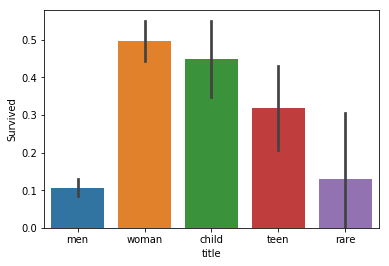

In [631]:
sns.barplot(x=df["title"], y=df["Survived"])

# Data Prep

In [632]:
df = df.fillna(0)

## missing values

In [633]:
from sklearn import preprocessing
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

## creating dummies

In [634]:
dummizar = ['Pclass', 'Sex', 'title']

df_antigo = df

for i in dummizar:
    df = create_dummies(df, i)

In [635]:
df.head()

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin Embarked     ...       \
0  22.0      1      0         A/5 21171   7.2500     0        S     ...        
1  38.0      1      0          PC 17599  71.2833   C85        C     ...        
2  26.0      0      0  STON/O2. 3101282   7.9250     0        S     ...        
3  35.0      1      0            113803  53.1000  C123        S     ...        
4  35.0      0      0            373450   8.0500     0        S     ...        

                              First_Name Family_Size Pclass_2 Pclass_3  \
0                            Owen Harris         2.0        0        1   
1  John Bradley (Florence Briggs Thayer)         2.0        0        0   
2                                  Laina         1.0        0        1   
3          Jacques Heath (Lily May Peel)         2.0        0        0   
4                          William Henry         2.0        0        1   

  Sex_male title_child title_men  title_rare  title_teen  title_woman  
0        1           0         1           0           0            0  
1        0           0         0           0           0            1  
2        0           0         0           0           0            1  
3        0           0         0           0           0            1  
4        1           0         1           0           0            0  

[5 rows x 26 columns]

# Separate Train and Test (kaggle dataset)

In [636]:
df_antigo_test = df_antigo[df_antigo["set"] == "test"]
df_antigo = df_antigo[df_antigo["set"] == "train"]

df_test = df[df["set"] == "test"]
df = df[df["set"] == "train"]

## separating numeric values

In [637]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
df_features = df.select_dtypes(include=numerics)
display(df_features.head())

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
df_features_test = df_test.select_dtypes(include=numerics)
display(df_features_test.head())

PassengerId  Survived   Age  SibSp  Parch     Fare  Family_Size  Pclass_2  \
0            1         0  22.0      1      0   7.2500          2.0         0   
1            2         1  38.0      1      0  71.2833          2.0         0   
2            3         1  26.0      0      0   7.9250          1.0         0   
3            4         1  35.0      1      0  53.1000          2.0         0   
4            5         0  35.0      0      0   8.0500          2.0         0   

   Pclass_3  Sex_male  title_child  title_men  title_rare  title_teen  \
0         1         1            0          1           0           0   
1         0         0            0          0           0           0   
2         1         0            0          0           0           0   
3         0         0            0          0           0           0   
4         1         1            0          1           0           0   

   title_woman  
0            0  
1            1  
2            1  
3            1  
4            0

PassengerId  Survived   Age  SibSp  Parch     Fare  Family_Size  \
891          892         0  34.5      0      0   7.8292          5.0   
892          893         0  47.0      1      0   7.0000          1.0   
893          894         0  62.0      0      0   9.6875          1.0   
894          895         0  27.0      0      0   8.6625          1.0   
895          896         0  22.0      1      1  12.2875          2.0   

     Pclass_2  Pclass_3  Sex_male  title_child  title_men  title_rare  \
891         0         1         1            0          1           0   
892         0         1         0            0          0           0   
893         1         0         1            0          1           0   
894         0         1         1            0          1           0   
895         0         1         0            0          0           0   

     title_teen  title_woman  
891           0            0  
892           0            1  
893           0            0  
894           0            0  
895           0            1

### descriptive new features

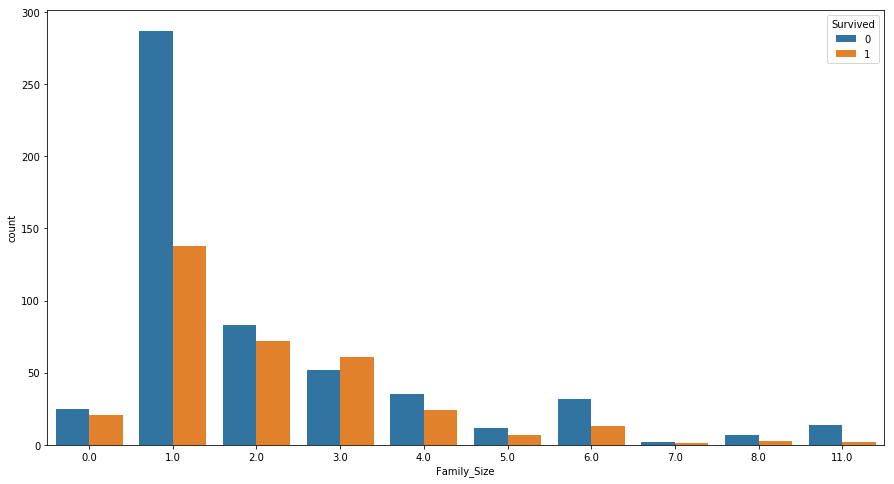

In [430]:
plt.figure(figsize=(15,8))
sns.countplot(df_antigo["Family_Size"], hue=df_antigo["Survived"], orient="h")

In [200]:
plt.figure(figsize=(20,10))
sns.countplot(y=df_antigo["pronoun"], hue=df_antigo["Survived"], orient="h")

In [201]:
plt.figure(figsize=(15,10))
sns.countplot(y=df_antigo["prefix_ticket"], hue=df_antigo["Survived"], orient="h")

<Figure size 432x288 with 0 Axes>

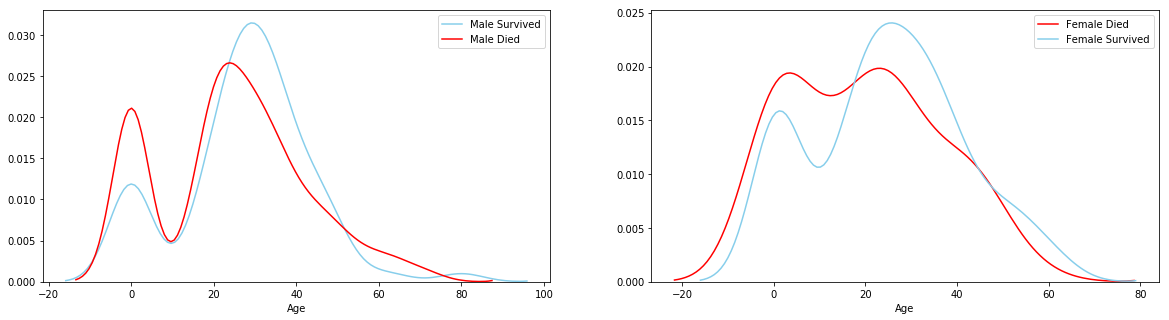

In [202]:
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(20,5))

df_antigo_male = df_antigo[df_antigo["title"] == "men"]
df_antigo_female = df_antigo[df_antigo["title"] == "woman"]

sns.distplot( df_antigo_male[df_antigo_male["Survived"]==1]["Age"], hist=False, color="skyblue", label="Male Survived", ax=axes[0])
sns.distplot( df_antigo_male[df_antigo_male["Survived"]==0]["Age"], hist=False, color="red", label="Male Died", ax=axes[0])

sns.distplot( df_antigo_female[df_antigo_female["Survived"]==0]["Age"] , hist=False, color="red", label="Female Died", ax=axes[1])
sns.distplot( df_antigo_female[df_antigo_female["Survived"]==1]["Age"] , hist=False, color="skyblue", label="Female Survived", ax=axes[1])

plt.legend()


In [203]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

boxen = sns.boxenplot(x='Survived', y='Age', hue='title', data=df_antigo, ax=axes[0]);
plt.setp(boxen.artists, alpha=.5, linewidth=2, edgecolor="k");

strip = sns.stripplot(x='Survived', y='Age', hue='title', data=df_antigo, ax=axes[1]);
plt.setp(strip.artists, alpha=.5, linewidth=2, edgecolor="k");

plt.xticks(rotation=45);

### separate the numeric values

In [146]:
quantitative_features_list = ["Sex_male","pronoun_Mr","Pclass_3","Fare","pronoun_Mrs","pronoun_Miss","Age","SibSp","Parch_1","cabin_prefx_B","cabin_prefx_D","cabin_prefx_E","Pclass_2","Parch_2","pronoun_Master","cabin_prefx_C","prefix_ticket_A","prefix_ticket_FCC","prefix_ticket_PC"]
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

KeyError: "['Sex_male' 'pronoun_Mr' 'pronoun_Mrs' 'pronoun_Miss' 'Parch_1' 'Parch_2'\n 'pronoun_Master'] not in index"

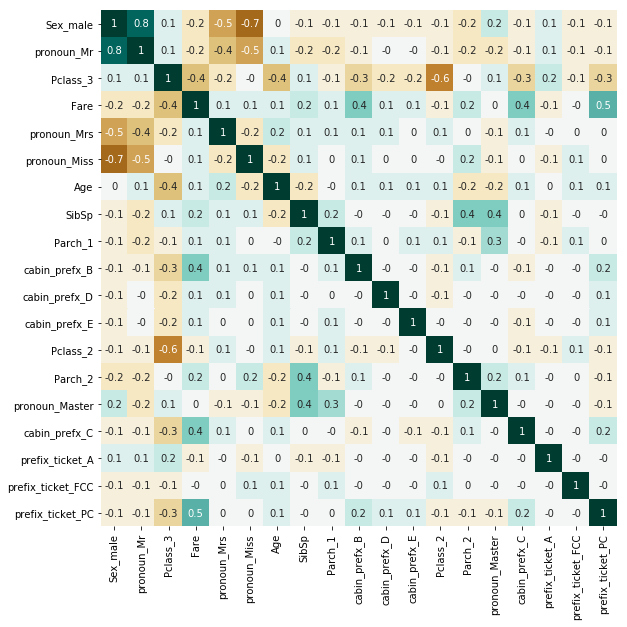

In [55]:
corr = df_quantitative_values.corr().round(1)
plt.figure(figsize=(len(corr)/2, len(corr)/2))

sns.heatmap(corr, cmap='BrBG', vmax=1.0, vmin=-1.0, center=0, annot=True, square=True, cbar=False);

# cross-validation

## hold-out (train e validation)

In [638]:
df_features.head()

PassengerId  Survived   Age  SibSp  Parch     Fare  Family_Size  Pclass_2  \
0            1         0  22.0      1      0   7.2500          2.0         0   
1            2         1  38.0      1      0  71.2833          2.0         0   
2            3         1  26.0      0      0   7.9250          1.0         0   
3            4         1  35.0      1      0  53.1000          2.0         0   
4            5         0  35.0      0      0   8.0500          2.0         0   

   Pclass_3  Sex_male  title_child  title_men  title_rare  title_teen  \
0         1         1            0          1           0           0   
1         0         0            0          0           0           0   
2         1         0            0          0           0           0   
3         0         0            0          0           0           0   
4         1         1            0          1           0           0   

   title_woman  
0            0  
1            1  
2            1  
3            1  
4            0

In [639]:
X_train = df_features.iloc[:, 2:]
y_train = df_features.iloc[:, 1]

In [640]:
display(X_train.head())
display(y_train.head())

Age  SibSp  Parch     Fare  Family_Size  Pclass_2  Pclass_3  Sex_male  \
0  22.0      1      0   7.2500          2.0         0         1         1   
1  38.0      1      0  71.2833          2.0         0         0         0   
2  26.0      0      0   7.9250          1.0         0         1         0   
3  35.0      1      0  53.1000          2.0         0         0         0   
4  35.0      0      0   8.0500          2.0         0         1         1   

   title_child  title_men  title_rare  title_teen  title_woman  
0            0          1           0           0            0  
1            0          0           0           0            1  
2            0          0           0           0            1  
3            0          0           0           0            1  
4            0          1           0           0            0

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## stratified kfold (train e test)

In [641]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train)
print(kf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


### restart measuring variables

In [642]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

# logistic regression

In [233]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

from sklearn.linear_model import LogisticRegression
rl = LogisticRegression()

for train_index,test_index in kf.split(X_train,y_train):
    
    X_train_kf, y_train_kf = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train.iloc[test_index], y_train.iloc[test_index]

    res = rl.fit(X_train_kf, y_train_kf)
    y_pred_kf = rl.predict(X_test_kf)
    
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logis

## validation - measuring results

Accuracy  Precision     Recall   F1-score
count  10.000000  10.000000  10.000000  10.000000
mean    0.821619   0.803651   0.716134   0.755631
std     0.041854   0.075827   0.053097   0.051965
min     0.741573   0.657143   0.647059   0.666667
25%     0.802778   0.760142   0.676471   0.743952
50%     0.825843   0.824507   0.705882   0.753861
75%     0.839888   0.847222   0.740966   0.776414
max     0.898876   0.903226   0.823529   0.861538

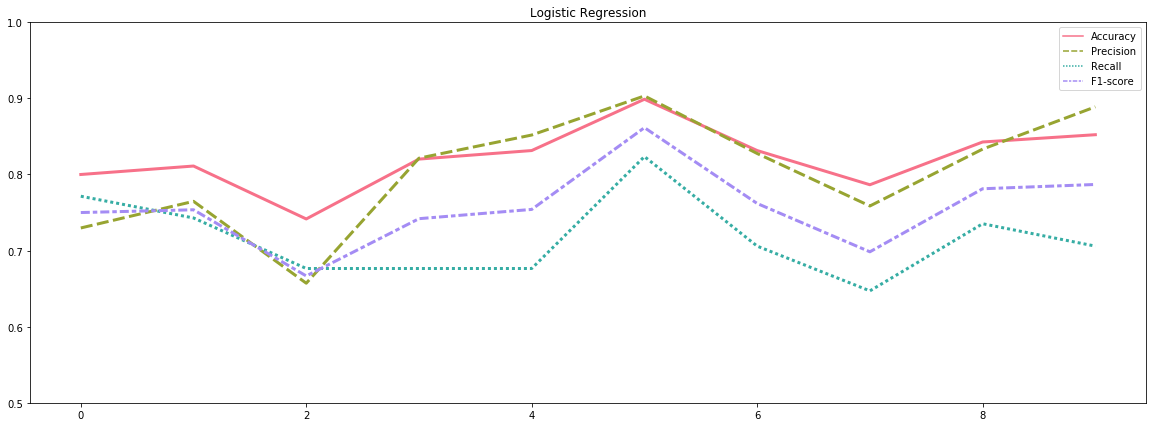

In [234]:
fig, axes = plt.subplots(1, 1, figsize=(20,7))
axes.set_title('Logistic Regression')
axes.set(ylim=(0.5, 1))
df_results = pd.DataFrame(list(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)), columns=["Accuracy", "Precision", "Recall", "F1-score"])
display(df_results.describe())
display(sns.lineplot(data=df_results, palette="husl", linewidth=3))

# Naive Bayes

In [63]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

for train_index,test_index in kf.split(X_train,y_train):
    X_train_kf, y_train_kf = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train.iloc[test_index], y_train.iloc[test_index]
    
    res = nb.fit(X_train_kf, y_train_kf)
#    importances = list(nb.feature_importances_)
    y_pred_kf = nb.predict(X_test_kf)
    
#    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

Accuracy  Precision     Recall   F1-score
count  10.000000  10.000000  10.000000  10.000000
mean    0.799285   0.745187   0.728319   0.735805
std     0.056910   0.081891   0.078436   0.076019
min     0.719101   0.638889   0.558824   0.603175
25%     0.753402   0.675290   0.685924   0.681159
50%     0.808989   0.746435   0.750000   0.753416
75%     0.828652   0.769748   0.794118   0.778133
max     0.876404   0.870968   0.794118   0.830769

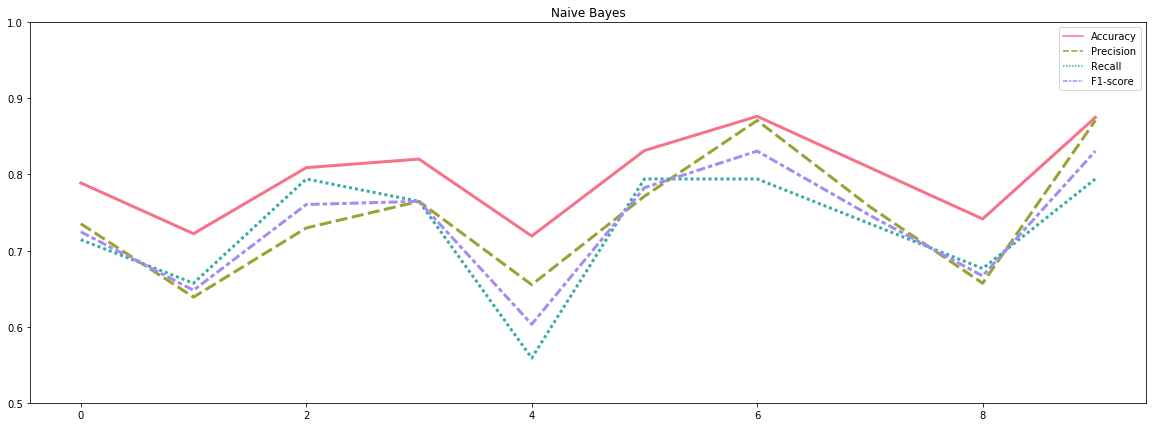

In [64]:
fig, axes = plt.subplots(1, 1, figsize=(20,7))
axes.set_title('Naive Bayes')
axes.set(ylim=(0.5, 1))
df_results = pd.DataFrame(list(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)), columns=["Accuracy", "Precision", "Recall", "F1-score"])
display(df_results.describe())
display(sns.lineplot(data=df_results, palette="husl", linewidth=3))

# Random Forest

## kfold (all predictors)

In [381]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 2000, max_depth=5)

for train_index,test_index in kf.split(X_train,y_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_kf, y_train_kf = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train.iloc[test_index], y_train.iloc[test_index]
    
    res = rf.fit(X_train_kf, y_train_kf)
    importances = list(rf.feature_importances_)
    y_pred_kf = rf.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

Accuracy  Precision     Recall   F1-score
count  10.000000  10.000000  10.000000  10.000000
mean    0.827061   0.814469   0.719076   0.760367
std     0.025106   0.056590   0.070380   0.038977
min     0.786517   0.727273   0.588235   0.701754
25%     0.808989   0.781609   0.683824   0.731443
50%     0.837079   0.818934   0.720588   0.759978
75%     0.842697   0.864286   0.764286   0.798529
max     0.855556   0.880000   0.823529   0.805970

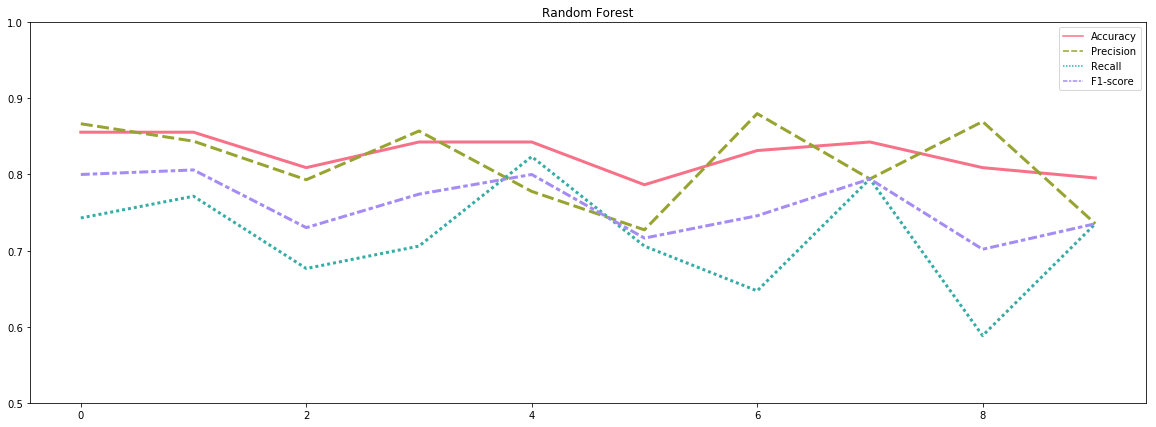

In [382]:
fig, axes = plt.subplots(1, 1, figsize=(20,7))
axes.set_title('Random Forest')
axes.set(ylim=(0.5, 1))
df_results = pd.DataFrame(list(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)), columns=["Accuracy", "Precision", "Recall", "F1-score"])
display(df_results.describe())
display(sns.lineplot(data=df_results, palette="husl", linewidth=3))

## feature importance analysis

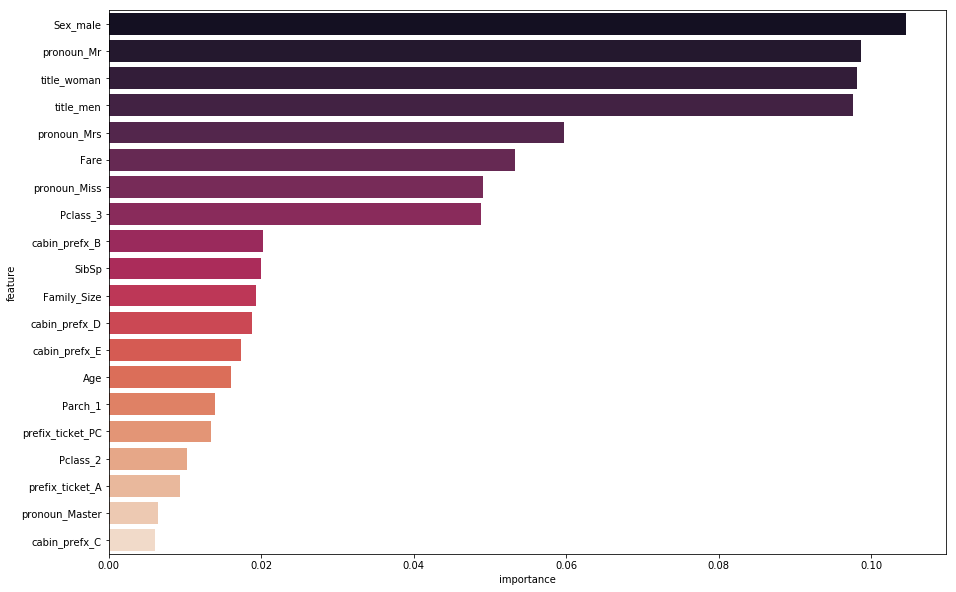

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(15,10))
feature_list = X_train.columns
df_features_importances = pd.DataFrame(list(zip(feature_list, importances)), columns=["feature", "importance"])
df_features_importances = df_features_importances.sort_values("importance", ascending=False)
plot_features = df_features_importances.head(20)
sns.barplot(y=plot_features["feature"], x=plot_features["importance"], palette="rocket")

# Randon Forest *20 most relevant features*

In [68]:
relevant_features = df_features_importances.iloc[:20, 0].values

In [69]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

X_train_fi = X_train[relevant_features]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 2000, max_depth=5)

for train_index,test_index in kf.split(X_train_fi,y_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_kf, y_train_kf = X_train_fi.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train_fi.iloc[test_index], y_train.iloc[test_index]
    
    res = rf.fit(X_train_kf, y_train_kf)
    importances = list(rf.feature_importances_)
    y_pred_kf = rf.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

## results

Accuracy  Precision     Recall   F1-score
count  10.000000  10.000000  10.000000  10.000000
mean    0.827237   0.808677   0.727983   0.764013
std     0.027914   0.058736   0.050482   0.033514
min     0.766667   0.684211   0.647059   0.709677
25%     0.820724   0.786255   0.691176   0.747628
50%     0.836121   0.809476   0.735294   0.767949
75%     0.842697   0.830357   0.742857   0.786222
max     0.865169   0.892857   0.823529   0.806452

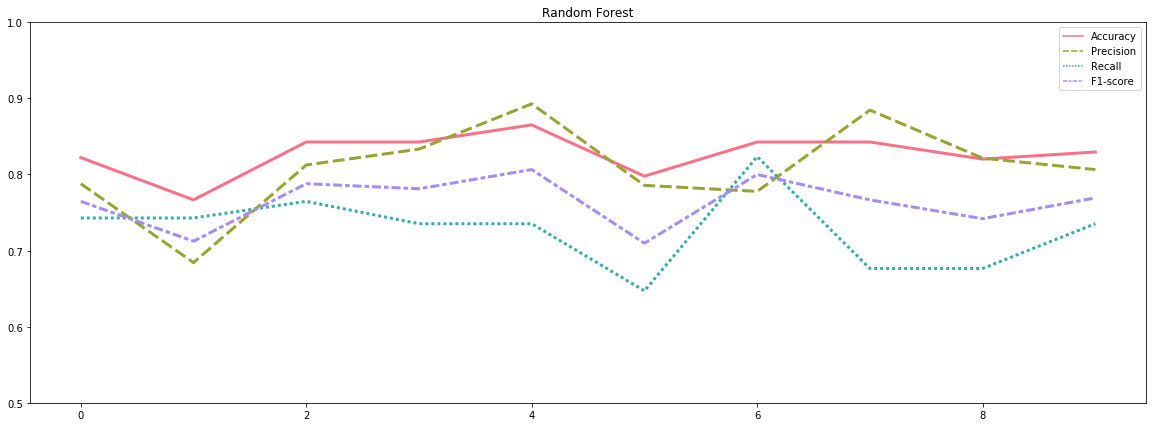

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(20,7))
axes.set_title('Random Forest')
axes.set(ylim=(0.5, 1))
df_results = pd.DataFrame(list(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)), columns=["Accuracy", "Precision", "Recall", "F1-score"])
display(df_results.describe())
display(sns.lineplot(data=df_results, palette="husl", linewidth=3))

## Feature importance reanalysed

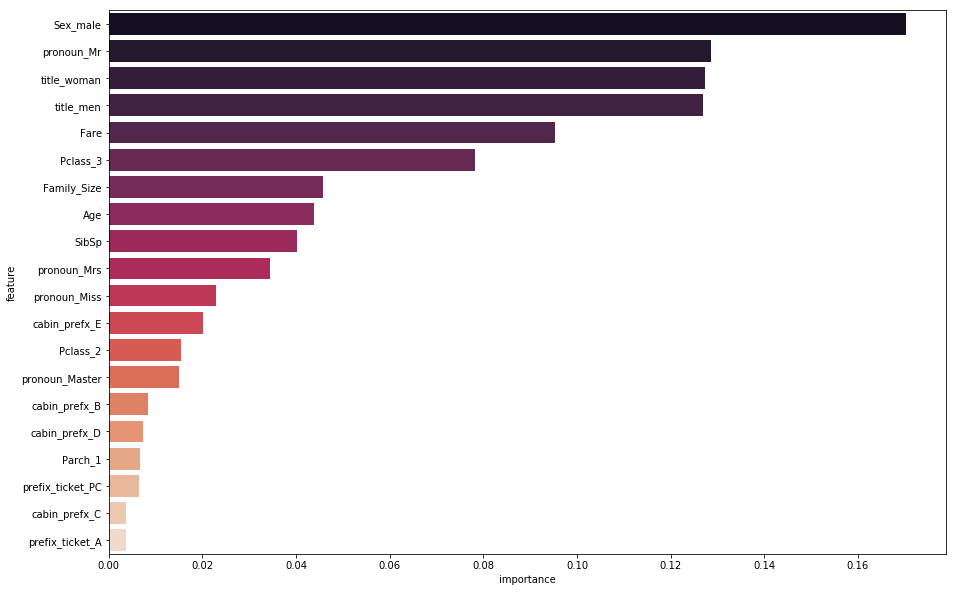

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(15,10))
feature_list = X_train_fi.columns
df_features_importances = pd.DataFrame(list(zip(feature_list, importances)), columns=["feature", "importance"])
df_features_importances = df_features_importances.sort_values("importance", ascending=False)
sns.barplot(y=df_features_importances["feature"], x=df_features_importances["importance"], palette="rocket")

# Gradient Boosting

In [684]:
relevant_features = ['Sex_male', 'Family_Size', 'title_child', 'Pclass_3']

In [685]:
X_train.head()

Age  SibSp  Parch     Fare  Family_Size  Pclass_2  Pclass_3  Sex_male  \
0  22.0      1      0   7.2500          2.0         0         1         1   
1  38.0      1      0  71.2833          2.0         0         0         0   
2  26.0      0      0   7.9250          1.0         0         1         0   
3  35.0      1      0  53.1000          2.0         0         0         0   
4  35.0      0      0   8.0500          2.0         0         1         1   

   title_child  title_men  title_rare  title_teen  title_woman  
0            0          1           0           0            0  
1            0          0           0           0            1  
2            0          0           0           0            1  
3            0          0           0           0            1  
4            0          1           0           0            0

In [686]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

X_train_fi = X_train[relevant_features]

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=2)

for train_index,test_index in kf.split(X_train_fi,y_train):
    X_train_kf, y_train_kf = X_train_fi.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train_fi.iloc[test_index], y_train.iloc[test_index]
    
    res = gb.fit(X_train_kf, y_train_kf)
    importances = list(gb.feature_importances_)
    y_pred_kf = gb.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

## Analyse result

Accuracy  Precision     Recall   F1-score
count  10.000000  10.000000  10.000000  10.000000
mean    0.812478   0.801197   0.683950   0.736814
std     0.036886   0.068824   0.054675   0.051784
min     0.752809   0.714286   0.588235   0.645161
25%     0.797753   0.765196   0.654412   0.711946
50%     0.810050   0.779954   0.691176   0.746042
75%     0.842697   0.849677   0.712185   0.777604
max     0.865169   0.923077   0.764706   0.800000

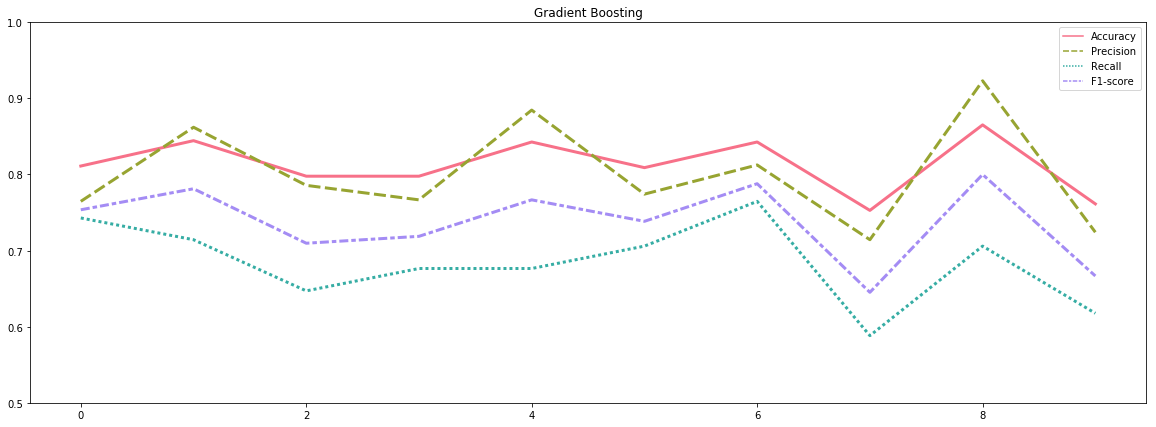

In [687]:
fig, axes = plt.subplots(1, 1, figsize=(20,7))
axes.set_title('Gradient Boosting')
axes.set(ylim=(0.5, 1))
df_results = pd.DataFrame(list(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)), columns=["Accuracy", "Precision", "Recall", "F1-score"])
display(df_results.describe())
display(sns.lineplot(data=df_results, palette="husl", linewidth=3))

## Feature Importances

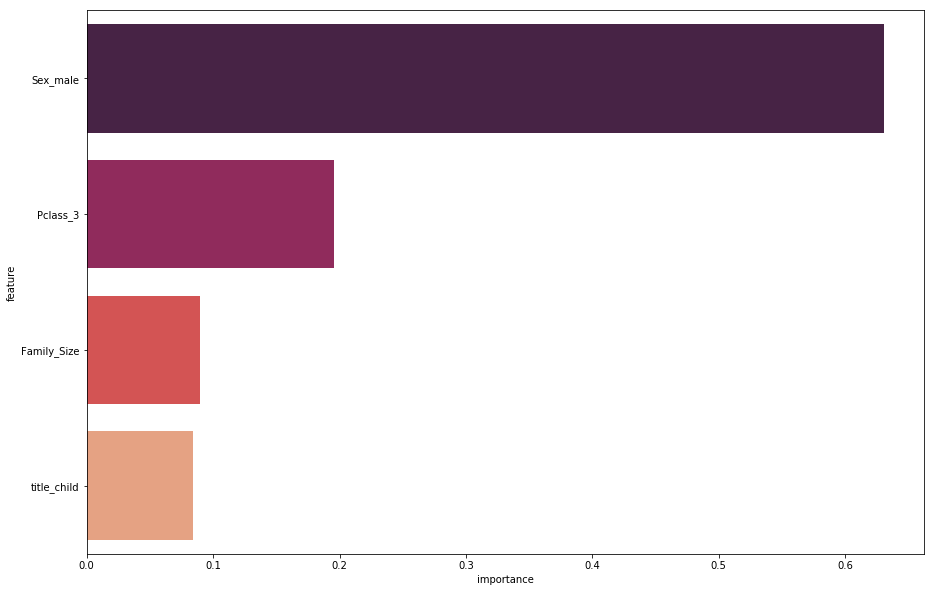

In [688]:
fig, axes = plt.subplots(1, 1, figsize=(15,10))
feature_list = X_train_fi.columns

df_vamos_ver = pd.DataFrame(feature_importances, columns=feature_list)
df_features_importances = pd.DataFrame(df_vamos_ver.describe().iloc[1,:]).reset_index()
df_features_importances.columns=["feature", "importance"]

df_features_importances = df_features_importances.sort_values("importance", ascending=False)
plot_features = df_features_importances.head(20)
sns.barplot(y=plot_features["feature"], x=plot_features["importance"], palette="rocket")

# Validation base - predict and submit

In [689]:
X_train_fi = X_train[relevant_features]
X_train_fi.head()

Sex_male  Family_Size  title_child  Pclass_3
0         1          2.0            0         1
1         0          2.0            0         0
2         0          1.0            0         1
3         0          2.0            0         0
4         1          2.0            0         1

In [690]:
classifier = gb
classifier.fit(X_train_fi, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [691]:
X_valid = df_features_test[relevant_features]
Ids = df_features_test.iloc[:, 0].reset_index()

In [692]:
X_valid.head()

Sex_male  Family_Size  title_child  Pclass_3
891         1          5.0            0         1
892         0          1.0            0         1
893         1          1.0            0         0
894         1          1.0            0         1
895         0          2.0            0         1

In [693]:
len(X_valid)

418

In [694]:
y_pred = classifier.predict(X_valid)
y_pred_df = pd.DataFrame(y_pred)

submit_base = pd.DataFrame(pd.concat([Ids["PassengerId"],y_pred_df], axis=1, ignore_index=True))
submit_base.columns = ["PassengerId","Survived"]
submit_base = submit_base.sort_values("PassengerId")
display(submit_base.head())

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [695]:
submit_base.to_csv("submission_simple_female.csv", index=False)

In [696]:
def cbind(df1, df2):
    concat_bases = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1, ignore_index=1)
    columns_names = np.append(df1.columns.values, df2.columns.values)
    concat_bases.columns=columns_names
    return concat_bases

In [697]:
submit_base_description = cbind(submit_base, df_test.iloc[:,2:])

In [698]:
submit_base_description.head()

PassengerId  Survived                                          Name   Age  \
0          892         0                              Kelly, Mr. James  34.5   
1          893         1              Wilkes, Mrs. James (Ellen Needs)  47.0   
2          894         0                     Myles, Mr. Thomas Francis  62.0   
3          895         0                              Wirz, Mr. Albert  27.0   
4          896         1  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  22.0   

   SibSp  Parch   Ticket     Fare Cabin Embarked     ...       \
0      0      0   330911   7.8292     0        Q     ...        
1      1      0   363272   7.0000     0        S     ...        
2      0      0   240276   9.6875     0        Q     ...        
3      0      0   315154   8.6625     0        S     ...        
4      1      1  3101298  12.2875     0        S     ...        

                      First_Name Family_Size Pclass_2 Pclass_3 Sex_male  \
0                          James         5.0        0        1        1   
1            James (Ellen Needs)         1.0        0        1        0   
2                 Thomas Francis         1.0        1        0        1   
3                         Albert         1.0        0        1        1   
4  Alexander (Helga E Lindqvist)         2.0        0        1        0   

  title_child title_men  title_rare  title_teen  title_woman  
0           0         1           0           0            0  
1           0         0           0           0            1  
2           0         1           0           0            0  
3           0         1           0           0            0  
4           0         0           0           0            1  

[5 rows x 26 columns]

In [699]:
sum(submit_base_description["Sex_male"]==1)

266

In [700]:
survived_df = submit_base_description[submit_base_description["Survived"]==1]
notsurvived_df = submit_base_description[submit_base_description["Survived"]==0]

In [701]:
survived_df.shape

(158, 26)

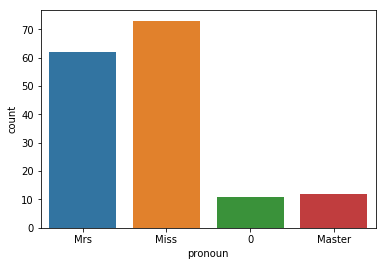

In [702]:
sns.countplot(survived_df["pronoun"])

In [703]:
survived_df[survived_df["Sex_male"]==1]

PassengerId  Survived                                               Name  \
21           913         1                          Olsen, Master. Artur Karl   
73           965         1                    Ovies y Rodriguez, Mr. Servando   
80           972         1                               Boulos, Master. Akar   
89           981         1                        Wells, Master. Ralph Lester   
144         1036         1  Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...   
161         1053         1                     Touma, Master. Georges Youssef   
194         1086         1                      Drew, Master. Marshall Brines   
196         1088         1                    Spedden, Master. Robert Douglas   
201         1093         1            Danbom, Master. Gilbert Sigvard Emanuel   
244         1136         1            Johnston, Master. William Arthur Willie   
281         1173         1                     Peacock, Master. Alfred Edward   
307         1199         1                          Aks, Master. Philip Frank   
336         1228         1                         de Brito, Mr. Jose Joaquim   
339         1231         1                              Betros, Master. Seman   
369         1261         1                      Pallas y Castello, Mr. Emilio   
417         1309         1                           Peter, Master. Michael J   

       Age  SibSp  Parch              Ticket      Fare Cabin Embarked  \
21    9.00      0      1             C 17368    3.1708     0        S   
73   28.50      0      0            PC 17562   27.7208   D43        C   
80    6.00      1      1                2678   15.2458     0        C   
89    2.00      1      1               29103   23.0000     0        S   
144  42.00      0      0               17475   26.5500     0        S   
161   7.00      1      1                2650   15.2458     0        C   
194   8.00      0      2               28220   32.5000     0        S   
196   6.00      0      2               16966  134.5000   E34        C   
201   0.33      0      2              347080   14.4000     0        S   
244   0.00      1      2          W./C. 6607   23.4500     0        S   
281   0.75      1      1  SOTON/O.Q. 3101315   13.7750     0        S   
307   0.83      0      1              392091    9.3500     0        S   
336  32.00      0      0              244360   13.0000     0        S   
339   0.00      0      0                2622    7.2292     0        C   
369  29.00      0      0       SC/PARIS 2147   13.8583     0        C   
417   0.00      1      1                2668   22.3583     0        C   

        ...                    First_Name Family_Size Pclass_2 Pclass_3  \
21      ...                    Artur Karl         4.0        0        1   
73      ...                             0         0.0        0        0   
80      ...                          Akar         4.0        0        1   
89      ...                  Ralph Lester         3.0        1        0   
144     ...                             0         0.0        0        0   
161     ...               Georges Youssef         3.0        0        1   
194     ...               Marshall Brines         3.0        1        0   
196     ...                Robert Douglas         3.0        0        0   
201     ...       Gilbert Sigvard Emanuel         3.0        0        1   
244     ...         William Arthur Willie         4.0        0        1   
281     ...                 Alfred Edward         3.0        0        1   
307     ...                  Philip Frank         2.0        0        1   
336     ...                             0         0.0        1        0   
339     ...                         Seman         2.0        0        1   
369     ...                             0         0.0        1        0   
417     ...                     Michael J         3.0        0        1   

    Sex_male title_child title_men  title_rare  title_teen  title_woman  
21         1           1         0 

In [704]:
notsurvived_df[notsurvived_df["Sex_male"]==0]

PassengerId  Survived                                             Name  \
32           924         0         Dean, Mrs. Bertram (Eva Georgetta Light)   
33           925         0  Johnston, Mrs. Andrew G (Elizabeth Lily Watson)   
37           929         0                               Cacic, Miss. Manda   
104          996         0          Thomas, Mrs. Alexander (Thamine Thelma)   
132         1024         0                    Lefebre, Mrs. Frank (Frances)   
140         1032         0                      Goodwin, Miss. Jessie Allis   
188         1080         0                                  Sage, Miss. Ada   
214         1106         0           Andersson, Miss. Ida Augusta Margareta   
309         1201         0       Hansen, Mrs. Claus Peter (Jennie L Howard)   
365         1257         0                   Sage, Mrs. John (Annie Bullen)   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked     ...       \
32   33.0      1      2   C.A. 2315  20.5750     0        S     ...        
33    0.0      1      2  W./C. 6607  23.4500     0        S     ...        
37   21.0      0      0      315087   8.6625     0        S     ...        
104  16.0      1      1        2625   8.5167     0        C     ...        
132   0.0      0      4        4133  25.4667     0        S     ...        
140  10.0      5      2     CA 2144  46.9000     0        S     ...        
188   0.0      8      2    CA. 2343  69.5500     0        S     ...        
214  38.0      4      2      347091   7.7750     0        S     ...        
309  45.0      1      0      350026  14.1083     0        S     ...        
365   0.0      1      9    CA. 2343  69.5500     0        S     ...        

                           First_Name Family_Size Pclass_2 Pclass_3 Sex_male  \
32      Bertram (Eva Georgetta Light)         4.0        0        1        0   
33   Andrew G (Elizabeth Lily Watson)         4.0        0        1        0   
37                              Manda         4.0        0        1        0   
104        Alexander (Thamine Thelma)         5.0        0        1        0   
132                   Frank (Frances)         5.0        0        1        0   
140                      Jessie Allis         8.0        0        1        0   
188                               Ada        11.0        0        1        0   
214             Ida Augusta Margareta        11.0        0        1        0   
309     Claus Peter (Jennie L Howard)         4.0        0        1        0   
365               John (Annie Bullen)        11.0        0        1        0   

    title_child title_men  title_rare  title_teen  title_woman  
32            0         0           0           0            1  
33            0         0           0           0            1  
37            0         0           0           0            1  
104           0         0           0           1            0  
132           0         0           0           0            1  
140           0         0           0           1            0  
188           0         0           0           0            1  
214           0         0           0           0            1  
309           0         0           0           0            1  
365           0         0           0           0            1  

[10 rows x 26 columns]